# Linear Elasticity: a Deformed Beam
We first setup the domain and solution space, together with the
vector valued discrete function $u$ which describes the displacement
field:

In [1]:
import matplotlib
matplotlib.rc( 'image', cmap='jet' )
from matplotlib import pyplot
from dune.fem.plotting import plotPointData as plot
from dune.grid import structuredGrid as leafGridView
from dune.fem.space import lagrange as solutionSpace
from dune.fem.scheme import galerkin as solutionScheme

from ufl import *
import dune.ufl

gridView = leafGridView([0, 0], [1, 0.15], [100, 15])
space = solutionSpace(gridView, dimRange=2, order=2, storage="istl")
displacement = space.interpolate([0,0], name="displacement")

We want clamped boundary conditions on the left, i.e., zero displacement

In [2]:
x = SpatialCoordinate(space)
dbc = dune.ufl.DirichletBC(space, as_vector([0,0]), x[0]<1e-10)

Next we define the variational problem starting with a few constants
describing material properties ($\mu,\lambda,\rho$) and the gravitational
force

In [3]:
mu = 1
lamb = 0.1
rho = 1/1000.
g = 9.8

Next we define the strain and stress
\begin{align*}
\epsilon(u) &= \frac{1}{2}(\nabla u + \nabla u^T) \\
\sigma(u)   &= 2\mu\epsilon(u) + \lambda\nabla\cdot u I
\end{align*}
where $I$ is the identity matrix.

In [4]:
epsilon = lambda u: 0.5*(nabla_grad(u) + nabla_grad(u).T)
sigma = lambda u: lamb*nabla_div(u)*Identity(2) + 2*mu*epsilon(u)

Finally we define the variational problem
\begin{align*}
\int_\Omega \sigma(u)\colon\epsilon(v) = \int_\Omega (0,-\rho g)\cdot v
\end{align*}
and solve the system

In [5]:
u = TrialFunction(space)
v = TestFunction(space)
equation = inner(sigma(u), epsilon(v))*dx == dot(as_vector([0,-rho*g]),v)*dx

scheme = solutionScheme([equation, dbc], solver='cg',
            parameters = {"newton.linear.preconditioning.method": "ilu"} )
info = scheme.solve(target=displacement)

We can directly plot the magnitude of the displacement field and the stress

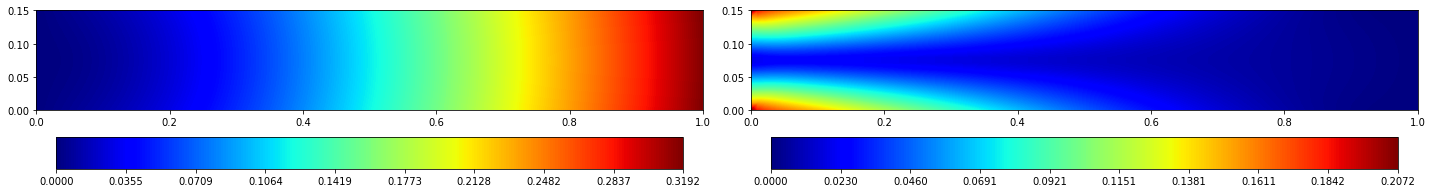

In [6]:
fig = pyplot.figure(figsize=(20,10))
displacement.plot(gridLines=None, figure=(fig, 121), colorbar="horizontal")
s = sigma(displacement) - (1./3)*tr(sigma(displacement))*Identity(2)
von_Mises = sqrt(3./2*inner(s, s))
plot(von_Mises, grid=gridView, gridLines=None, figure=(fig, 122), colorbar="horizontal")

Finally we can plot the actual displaced beam using a grid view that
allows us to add a transformation of the geometry of each entity in the
grid by prociding a grid function to the constructor. Note that this also
allows for higher order transformation like in this case where the
transformation is given by a second order Lagrange discrete function.
We will highlight the flexibility of the # `GeometryGridView` in further
examples:

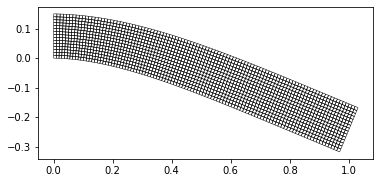

In [7]:
from dune.fem.view import geometryGridView
position = space.interpolate( x+displacement, name="position" )
beam = geometryGridView( position )
beam.plot()